신경망-> 비트코인 가격 예측 모델   
RNN -> 주식 예측 모델  
pip install yfinance

In [91]:
# !pip install yfinance
import yfinance as yf

In [92]:
df= yf.download('BTC-USD', '2020-01-01', '2020-07-27')

[*********************100%***********************]  1 of 1 completed


In [93]:
#우린 파일 사용..
%matplotlib inline
import os

In [94]:
df=pd.read_csv("bitcoin.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-01,963.66,1003.08,958.70,998.33,998.33,147775008
1,2017-01-02,998.62,1031.39,996.70,1021.75,1021.75,222184992
2,2017-01-03,1021.60,1044.08,1021.60,1043.84,1043.84,185168000
3,2017-01-04,1044.40,1159.42,1044.40,1154.73,1154.73,344945984
4,2017-01-05,1156.73,1191.10,910.42,1013.38,1013.38,510199008


In [95]:
dfClose=pd.DataFrame(df['Close'])

In [96]:
dfClose.index=pd.to_datetime(df['Date'])

In [97]:
dfClose


,Close
Date,
2017-01-01,998.33
2017-01-02,1021.75
2017-01-03,1043.84
2017-01-04,1154.73
2017-01-05,1013.38
...,...
2019-11-11,8757.79
2019-11-12,8815.66
2019-11-13,8808.26


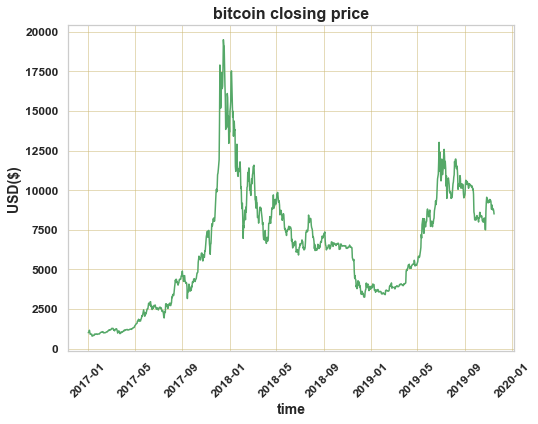

In [98]:
plt.figure(figsize=(8,6))
plt.plot(dfClose, color='g')
plt.title('bitcoin closing price', weight= 'bold', fontsize=16)
plt.xlabel('time', weight= 'bold', fontsize=14)
plt.ylabel('USD($)', weight= 'bold', fontsize=14)
plt.xticks(weight= 'bold', fontsize=12, rotation =45)
plt.yticks(weight= 'bold', fontsize=12)
plt.grid(color='y', linewidth=0.5)

과거 15일 간의 비트코인 가격입력 -> 오늘의 가격 예측  
https://otexts.com/fppkr/AR.html  
시계열을 신경망에 쓸 수 있는 아이디어 1  


In [99]:
"""
과거 15일 동안의 비트코인 가격 입력 -> 오늘의 가격 예측
"""
listOfAttributes=['Close']
listOfPrevTInstants=[]
for i in range(1,16):
    listOfPrevTInstants.append(i)
listOfPrevTInstants

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [100]:
def createRegressorAttributes(df, attribute, listOfPrevTInstants): # 변수3개
    listOfPrevTInstants.sort()
    start=listOfPrevTInstants[-1] # 15(시작)
    end=len(df) #1049 (끝)
    df['datetime']=df.index # 2017-01-01 ~ 2019-11-15
    df.reset_index(drop=True)
    # print(df)
    dfCopy = df[start:end]
    dfCopy.reset_index(inplace=True, drop=True)
    for attr in attribute: #[15]
        foobar=pd.DataFrame()
        for prevT in listOfPrevTInstants: #[1~15]   prevT:1~15까지의 값 반복 
            #                                 15-prevT(1)=14: 1049-prevT(1)=1048
            newCol=pd.DataFrame(df[attr].iloc[(start-prevT) : (end-prevT)])
            newCol.reset_index(drop=True, inplace=True)
            newCol.rename(columns={attr:'{}_(t-{})'.format(attr,prevT)},inplace=True)
            foobar=pd.concat([foobar, newCol], sort=False, axis=1)
        dfCopy=pd.concat([dfCopy, foobar], sort=False, axis=1)
    dfCopy.set_index(['datetime'], drop=True, inplace=True)
    return dfCopy

In [101]:
dfNew=createRegressorAttributes(dfClose, listOfAttributes, listOfPrevTInstants)
print(dfNew)
dfNew.info()
dfNew.shape

Close  Close_(t-1)  Close_(t-2)  Close_(t-3)  Close_(t-4)  \
datetime                                                                  
2017-01-16   831.53       821.80       818.41       823.98       804.83   
2017-01-17   907.94       831.53       821.80       818.41       823.98   
2017-01-18   886.62       907.94       831.53       821.80       818.41   
2017-01-19   899.07       886.62       907.94       831.53       821.80   
2017-01-20   895.03       899.07       886.62       907.94       831.53   
...             ...          ...          ...          ...          ...   
2019-11-11  8757.79      9055.53      8813.58      8804.88      9267.56   
2019-11-12  8815.66      8757.79      9055.53      8813.58      8804.88   
2019-11-13  8808.26      8815.66      8757.79      9055.53      8813.58   
2019-11-14  8708.09      8808.26      8815.66      8757.79      9055.53   
2019-11-15  8491.99      8708.09      8808.26      8815.66      8757.79   

            Close_(t-5)  Close_(t-6)  

(1034, 16)

In [102]:
from keras.layers import *
from keras.models import *
from keras.optimizers import SGD

In [103]:
inputLayer =Input(shape=(15), dtype='float32')
dense1= Dense(60, activation='linear')(inputLayer)
dense2= Dense(60, activation='linear')(dense1)
dropLayer=Dropout(0.2)(dense2)
outputLayer=Dense(1, activation='linear')(dropLayer)

In [104]:
model = Model(inputs=inputLayer, outputs= outputLayer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 60)                960       
_________________________________________________________________
dense_7 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 4,681
Trainable params: 4,681
Non-trainable params: 0
_________________________________________________________________


In [105]:
testSetSize=0.05
valdSetSize=0.05
dfCopy=dfNew.reset_index(drop=True)

In [106]:
dfCopy #0~1033
# int(np.floor(len(dfCopy)*(1-testSetSize))) #982.3 -> floor:982.0 -> int 982
dfTest=dfCopy.iloc[int(np.floor(len(dfCopy)*(1-testSetSize))) :]
dfTrainValid=dfCopy.iloc[ : int(np.floor(len(dfCopy)*(1-testSetSize)))]

In [107]:
dfValid=dfTrainValid.iloc[int(np.floor(len(dfTrainValid)*(1-valdSetSize))):]
dfTrain=dfTrainValid.iloc[:int(np.floor(len(dfTrainValid)*(1-valdSetSize)))]
print(dfValid.shape)
print(dfTrain.shape)
print(dfTest.shape)

(50, 16)
(932, 16)
(52, 16)


In [108]:
xTrain, yTrain = dfTrain.iloc[:,1:], dfTrain.iloc[:,0]
xTest, yTest = dfTest.iloc[:,1:], dfTest.iloc[:,0]
xValid, yValid = dfValid.iloc[:,1:], dfValid.iloc[:,0]
print(xTrain.shape,yTrain.shape)
print(xTest.shape,yTest.shape)
print(xValid.shape,yValid.shape)

(932, 15) (932,)
(52, 15) (52,)
(50, 15) (50,)


In [109]:
from sklearn.preprocessing import MinMaxScaler

In [110]:
scaler =MinMaxScaler(feature_range=(0.01, 0.99))

In [111]:
xTrainScaled=scaler.fit_transform(np.array(xTrain))
xValidScaled=scaler.fit_transform(np.array(xValid))
xTestScaled=scaler.fit_transform(np.array(xTest))

In [112]:
yTrainScaled=scaler.fit_transform(np.array(yTrain).reshape(-1,1))
yValidScaled=scaler.fit_transform(np.array(yValid).reshape(-1,1))
yTestScaled=scaler.fit_transform(np.array(yTest).reshape(-1,1))

In [113]:
print(xTrainScaled.shape)
print(xValidScaled.shape)
print(xTestScaled.shape)
print(yTrainScaled.shape)
print(yValidScaled.shape)
print(yTestScaled.shape)

(932, 15)
(50, 15)
(52, 15)
(932, 1)
(50, 1)
(52, 1)


In [114]:
model.fit(x=xTrainScaled, y=yTrainScaled, batch_size=5, epochs=30, validation_data=(xValidScaled, yValidScaled), shuffle=True)

Epoch 1/30
187/187 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0611
Epoch 2/30
187/187 [==============================] - 0s 827us/step - loss: 0.0068 - val_loss: 0.0711
Epoch 3/30
187/187 [==============================] - 0s 987us/step - loss: 0.0030 - val_loss: 0.0524
Epoch 4/30
187/187 [==============================] - 0s 912us/step - loss: 0.0025 - val_loss: 0.0566
Epoch 5/30
187/187 [==============================] - 0s 789us/step - loss: 0.0024 - val_loss: 0.0405
Epoch 6/30
187/187 [==============================] - 0s 763us/step - loss: 0.0020 - val_loss: 0.0289
Epoch 7/30
187/187 [==============================] - 0s 773us/step - loss: 0.0018 - val_loss: 0.0423
Epoch 8/30
187/187 [==============================] - 0s 901us/step - loss: 0.0017 - val_loss: 0.0243
Epoch 9/30
187/187 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0321
Epoch 10/30
187/187 [==============================] - 0s 768us/step - loss: 0.0019 - 

In [115]:
#역정규화: 원래대로 
yPred=model.predict(xTestScaled)
# yPred

In [116]:
yPredReScaled=scaler.inverse_transform(yPred)

In [117]:
yTestReScaled=scaler.inverse_transform(yTestScaled)

In [118]:
from sklearn.metrics import r2_score

In [119]:
yTestReScaled=scaler.inverse_transform(yTestScaled)
score=r2_score(yTestReScaled, yPredReScaled)
print(score)

0.7188622100671128


주식예측


In [120]:
xy=np.loadtxt("stock_daily.csv", delimiter=",")
xy

array([[8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02],
       [8.19929993e+02, 8.24400024e+02, 8.18979980e+02, 1.28170000e+06,
        8.24159973e+02],
       ...,
       [5.66892592e+02, 5.67002574e+02, 5.56932537e+02, 1.08000000e+04,
        5.56972503e+02],
       [5.61202549e+02, 5.66432590e+02, 5.58672539e+02, 4.12000000e+04,
        5.59992565e+02],
       [5.68002570e+02, 5.68002570e+02, 5.52922516e+02, 1.31000000e+04,
        5.58462551e+02]])

In [121]:
xy = xy[::-1] #앞뒤 순서가 바뀐다  뒤에서부터 데이터가 읽어짐

In [122]:
scaler=MinMaxScaler(feature_range=(0,1))
xy = scaler.fit_transform(xy)
x=xy
y=xy[:,[-1]] # close, 종가 

In [123]:
xData = []
yData = []
seqLength =7 #7일 단위로 트레이닝

In [124]:
for i in range(0, len(y)-seqLength):
    xx=x[i:i+seqLength]
    yy=y[i+seqLength]
    # print(xx,"->",yy)
    xData.append(xx)
    yData.append(yy)

In [125]:
np.shape(xData)

(725, 7, 5)

In [126]:
trainSize=int(len(xData)*0.7)
testSizr=len(yData)-trainSize

In [127]:
trainX, testX=np.array(xData[0:trainSize]), np.array(xData[trainSize:len(xData)])
trainY, testY=np.array(yData[0:trainSize]), np.array(yData[trainSize:len(yData)])

In [128]:
trainY.shape

(507, 1)

In [129]:
model=Sequential()
model.add(LSTM(1, input_shape=(7,5), return_sequences=False))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error',optimizer='adam' )
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1)                 28        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.fit(trainX, trainY, epochs=200)

Epoch 1/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4819
Epoch 2/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4300
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3803
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3338
Epoch 5/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2922
Epoch 6/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2567
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2280
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.2040
Epoch 9/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1839
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1675
Epoch 11/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1536
Epoch 12/200
16/16 [==============================] - 0s 2ms/step - loss: 0.1414
Epoch 13/200
16/16 [=================

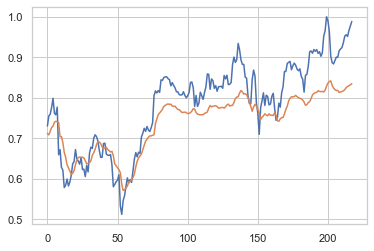

In [131]:
testPredict=model.predict(testX)
plt.plot(testY)
plt.plot(testPredict)